In [7]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

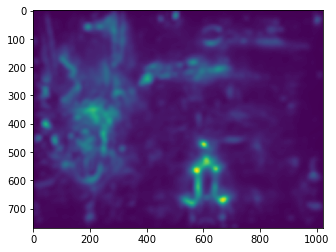

(768, 1024)


In [13]:
priority_map = np.double(np.array(Image.open('PriorityMap.png')))
priority_map = priority_map/np.max(priority_map)
plt.imshow(priority_map)
plt.show()

im_size = priority_map.shape
print(im_size)
im_h = im_size[0]
im_w = im_size[1]

if(len(im_size) > 2):
    priority_map = np.mean(priority_map,axis=2);
    
# set the initial fixation at center
row_im_f = math.floor(im_h/2) ;
col_im_f = math.floor(im_w/2) ;
RETINA_PIXDEG = 30 ; 

In [3]:
# Helper Functions
#  --------------------------------------------------------------------

def coll2vis(u, v):
    RETINA_A = 3.0    
    RETINA_BU = 1.4 
    RETINA_BV = 1.8  

    R=RETINA_A* np.sqrt( np.exp(2*u/RETINA_BU)- np.multiply(2*np.exp(u/RETINA_BU), np.cos(v/RETINA_BV)) + 1 ) 
    phi=np.arctan( np.divide(np.multiply(np.exp(u/RETINA_BU), np.sin(v/RETINA_BV) ), np.multiply(np.exp(u/RETINA_BU) , np.cos(v/RETINA_BV))-1.0))  
    return [R,phi]


def gauss2D(shape=(3,3),sigma=0.5):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


def frame_the_map(activation_map, SC_frame):
    map_framed = np.expand_dims(activation_map, axis=2)
    map_framed = np.tile(map_framed,[1, 1, 3])
    map_framed[SC_frame != 0] = SC_frame[SC_frame != 0]
    return map_framed 


In [14]:
# Set parameters
#  --------------------------------------------------------------------

Visual_Point_Image = 1   #set this to zero if you want less avearging/blurring
VISUAL_DIAMETER = 1.6  # mm
VISUAL_SIGMA = .4  # mm
Motor_Point_Image = 1 
MOTOR_DIAMETER = 2.4  # mm
MOTOR_SIGMA = .6 

ave_across_Coll = 1 

# System Parameters - don't change
RETINA_A = 3.0
RETINA_BU = 1.4 
RETINA_BV = 1.8  
RETINA_FOVEA = 0.5 
map_w = int(640) 
map_h = 480 
PIX_MM = 76   # map_pixels per mm of SC

#  --------------------------------------------------------------------
# read in maps and frames 
#  --------------------------------------------------------------------

filt_v = gauss2D( (math.floor(VISUAL_DIAMETER*PIX_MM), math.floor(VISUAL_DIAMETER*PIX_MM)), math.floor(VISUAL_SIGMA*PIX_MM))
filt_m = gauss2D( (math.floor(MOTOR_DIAMETER*PIX_MM),  math.floor(MOTOR_DIAMETER*PIX_MM)), math.floor(MOTOR_SIGMA*PIX_MM))  ;

across_Coll = np.load('across_coll.npy')
mask_fill = np.array(Image.open('mask_fill.png'))
SC_frame = np.array(Image.open('SC_frame.png'))
SC_frame = SC_frame/np.max(SC_frame)

x_sign = np.concatenate((np.ones((1,int(map_w/2))),np.negative(np.ones((1,int(map_w/2))))),axis=1)  
y_sign = 1

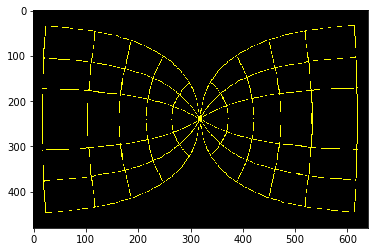

In [15]:
plt.imshow(SC_frame, aspect='auto')
plt.show()

In [16]:
#  Saliency Map in Colliclus - Porjecting and then Applying visual point image
#  --------------------------------------------------------------------

sal_project = np.zeros((map_h,map_w)) 
sal_coll = np.zeros((map_h,map_w)) 
col = np.array([i for i in range(map_w)])
u = abs( ( col - math.floor(map_w/2) ) / PIX_MM ) ;

for row in range(map_h):
    v = ( ( map_h / 2 ) - row ) / PIX_MM 
    [R,phi] = coll2vis(u,v)

    col_diff = np.int32( RETINA_PIXDEG* np.multiply(R , np.cos(phi)))
    row_diff = np.int32( RETINA_PIXDEG* np.multiply(R , np.sin(phi)))
    col_im = np.int32(col_im_f + np.multiply(x_sign , col_diff))
    row_im = np.int32(np.reshape(row_im_f + (y_sign * row_diff), (1,map_w)))

    acc_index = (row_im > 0) & (row_im < im_h ) & (col_im > 0) & (col_im < im_w ) & ( mask_fill[row,:] < 50 ) 
    sal_project[row][np.squeeze(acc_index)] = priority_map[ row_im[acc_index] , col_im[acc_index] ]

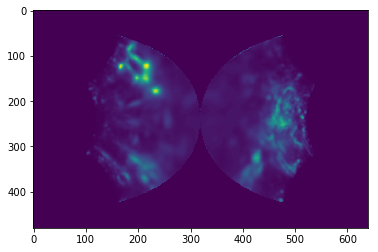

1.0


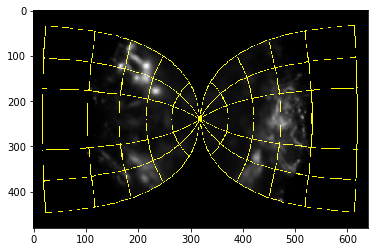

In [17]:
plt.imshow(sal_project/np.max(sal_project), aspect='auto')
plt.show()

sal_project_framed = frame_the_map(sal_project/np.max(sal_project), SC_frame)
print(np.max(sal_project))

plt.imshow(sal_project_framed/np.max(sal_project_framed), aspect='auto')
plt.show()
#scipy.misc.imsave('outfile.jpg', sal_project_framed)

In [18]:
# Applying visual point image
#--------------------------------------------------------------------

Visual_Point_Image = 1
if(Visual_Point_Image == 1):
    sal_coll[:,0:int(map_w/2)] = signal.fftconvolve(sal_project[:,0:int(map_w/2)], filt_v, mode='same')
    sal_coll[:,int(map_w/2):map_w] = signal.fftconvolve(sal_project[:,int(map_w/2):map_w], filt_v, mode='same')
    sal_coll = np.multiply(sal_coll , ( mask_fill < 50 ) )
else:
    sal_coll = np.multiply(sal_project , ( mask_fill < 50 ) )
    

    # check whether the map is completely empty
if( np.max(sal_coll) == 0):
    print('The saliency map is empty')

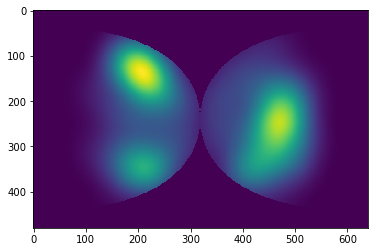

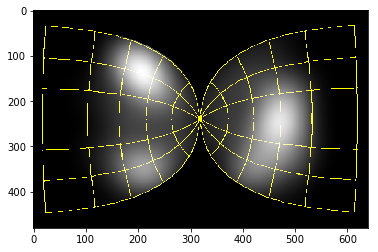

In [19]:
plt.imshow(sal_coll, aspect='auto')
plt.show()

sal_Coll_framed = frame_the_map(sal_coll/np.max(sal_coll), SC_frame)
plt.imshow(sal_Coll_framed, aspect='auto')
plt.show()

In [20]:
# Applying Motor Point Image
#--------------------------------------------------------------------

moto_Coll = np.zeros((map_h,map_w)) 
Rcoll = np.zeros((2*map_h,map_w))
Lcoll = np.zeros((2*map_h,map_w))

if(Motor_Point_Image == 1):
    if(ave_across_Coll):
        Lcoll[int(map_h/2):map_h+int(map_h/2) , 0:int(map_w/2)] = sal_coll[:,0:int(map_w/2)] 
        Rcoll[int(map_h/2):map_h+int(map_h/2) , int(map_w/2):map_w] = sal_coll[:,int(map_w/2):map_w] 
        moto_Lcoll = signal.fftconvolve(Lcoll, filt_m, mode='same')
        moto_Rcoll = signal.fftconvolve(Rcoll, filt_m, mode='same')
        
        for row in range(map_h):
            col =( mask_fill[row,0:int(map_w)] < 50) & np.squeeze((np.concatenate((np.ones((1,int(map_w/2)),dtype=int), \
                        np.zeros((1,int(map_w/2)),dtype=int)), axis = 1))>0) 
            if any(col):
                moto_Coll[row,col]= moto_Lcoll[row+int(map_h/2) , col] + \
                    moto_Rcoll[int(map_h/2) + across_Coll[row,col,0], across_Coll[row,col,1]] 
                    
                col= ( mask_fill[row,0:int(map_w)] < 50) & np.squeeze((np.concatenate((np.zeros((1,int(map_w/2)),dtype=int), \
                    np.ones((1,int(map_w/2)),dtype=int)), axis = 1))>0) 

                moto_Coll[row,col]= moto_Rcoll[row+int(map_h/2) , col] + \
                    moto_Lcoll[int(map_h/2) + across_Coll[row,col,0], across_Coll[row,col,1]] 
                    
    else:  # ave_across_Coll = 0
        moto_Coll[:,0:int(map_w/2)] = signal.fftconvolve(sal_coll[:,0:int(map_w/2)], filt_m, mode='same')
        moto_Coll[:,int(map_w/2):map_w] = signal.fftconvolve(sal_coll[:,int(map_w/2):map_w], filt_m, mode='same')
        
else: # Motor_Point_Image =0
    moto_Coll = sal_coll 

moto_Coll = np.multiply(moto_Coll , ( mask_fill < 50 ) )


In [21]:
# determine the winning population in SC
#--------------------------------------------------------------------

argmax_ind = np.argmax(moto_Coll)
[row_m, col_m] = np.unravel_index(argmax_ind, (map_h,map_w))

if (mask_fill[row_m-1,col_m] == 255 or mask_fill[row_m-2,col_m] == 255 ):
    row_m = row_m + 2 
elif ( mask_fill[row_m+1,col_m] == 255 or mask_fill[row_m+2,col_m] == 255 ):
    row_m = row_m - 2 ;

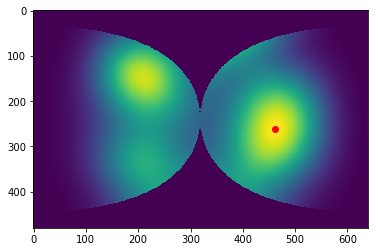

0.151578404875


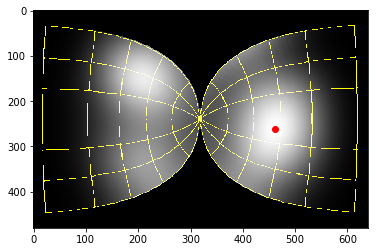

In [22]:
plt.imshow(moto_Coll, aspect='auto')
plt.plot(col_m, row_m, 'o',color='red')
plt.show()

print(np.max(moto_Coll))
moto_Coll_framed = frame_the_map(moto_Coll/np.max(moto_Coll), SC_frame)
plt.imshow(moto_Coll_framed, aspect='auto')
plt.plot(col_m, row_m, 'o',color='red')
plt.show()
#scipy.misc.imsave('moto_Coll_framed.jpg', moto_Coll_framed)

In [24]:
    
# Convert back to image space
u_m = abs( ( col_m - map_w/2 ) / PIX_MM )  
v_m = ( ( map_h / 2 ) - row_m ) / PIX_MM   
[R,phi] = coll2vis(u_m,v_m)

col_diff = np.int32( RETINA_PIXDEG* np.multiply(R , np.cos(phi)))
row_diff = np.int32( RETINA_PIXDEG* np.multiply(R , np.sin(phi)))
col_im_m = np.int32(col_im_f + np.sign( map_w/2 - col_m ) * col_diff) 
row_im_m = row_im_f + row_diff ;

col_im_m = np.clip(col_im_m,1, im_w-1)
row_im_m = np.clip(row_im_m,1, im_h-1)

In [25]:
print([row_im_f, col_im_m])
print([col_im_f, row_im_m])

[384, 265]
[512, 332]


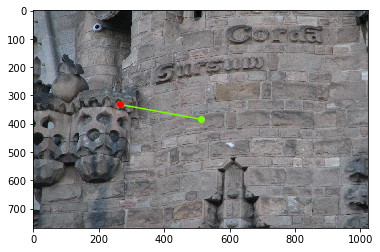

In [26]:
scene_image = np.array(Image.open('1.jpg'))
plt.imshow(scene_image, aspect='auto')

plt.plot([col_im_f, col_im_m], [row_im_f, row_im_m], '-o', color='lawngreen')
plt.plot(col_im_m, row_im_m, 'o',color='red')
plt.savefig('saccade_scene_1.jpg')
plt.show()

In [20]:
#update the current fixation
row_im_f = np.double(row_im_m)  
col_im_f = np.double(col_im_m)  